In [1]:
# feature importances
from rfpimp import permutation_importances
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# clustering 1d array
from scipy.signal import argrelextrema
from sklearn.neighbors.kde import KernelDensity

# data processing
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# visualization
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# db operations
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
def connect():
    conn_args = {'check_same_thread': False}
    engine = create_engine('sqlite:///../recommendation.db', connect_args=conn_args)
    return sessionmaker(bind=engine)()

In [3]:
session = connect()
raw = pd.read_sql(con=session.bind, sql='SELECT * FROM movies')
session.close()

#### Intro

In [4]:
df = raw.dropna(subset=['genres', 'runtime'])

In [5]:
df.head()

,movie_id,title,primary_title,genres,kind,description,image_url,average_rating,num_votes,start_year,end_year,is_adult,runtime
0,tt0003037,Juve contre Fantômas,Fantomas: The Man in Black,"Crime,Drama",movie,Juve contre Fantômas is a movie starring René ...,https://m.media-amazon.com/images/M/MV5BMTFkM2...,6.9,1250,1913,NaN,0,61.0
1,tt0005489,His New Job,His New Job,"Comedy,Short",short,His New Job is a short starring Charles Chapli...,https://m.media-amazon.com/images/M/MV5BMTU4ND...,6.2,1411,1915,NaN,0,31.0
2,tt0007761,The Butcher Boy,The Butcher Boy,"Comedy,Short",short,The Butcher Boy is a short starring Roscoe 'Fa...,https://m.media-amazon.com/images/M/MV5BMzU5Mz...,6.4,1186,1917,NaN,0,30.0
3,tt0002381,The Musketeers of Pig Alley,The Musketeers of Pig Alley,"Crime,Drama,Short",short,The Musketeers of Pig Alley is a short starrin...,https://m.media-amazon.com/images/M/MV5BMTkyNz...,6.7,1763,1912,NaN,0,17.0
4,tt0000091,Le manoir du diable,The House of the Devil,"Horror,Short",short,Le manoir du diable is a short starring Jehann...,https://m.media-amazon.com/images/M/MV5BY2RkZD...,6.7,2293,1896,NaN,0,3.0


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
average_rating,32744.0,6.750754,1.061694,1.3,6.1,6.9,7.5,10.0
num_votes,32744.0,23958.107012,78475.787272,789.0,1861.0,3703.5,11901.0,2058941.0
start_year,32744.0,1996.381505,21.429513,1878.0,1988.0,2004.0,2012.0,2019.0
end_year,2965.0,2004.064418,13.477385,1956.0,1998.0,2009.0,2014.0,2020.0
is_adult,32744.0,0.000244,0.015629,0.0,0.0,0.0,0.0,1.0
runtime,32744.0,97.732684,48.114130,0.0,85.0,97.0,112.0,1620.0


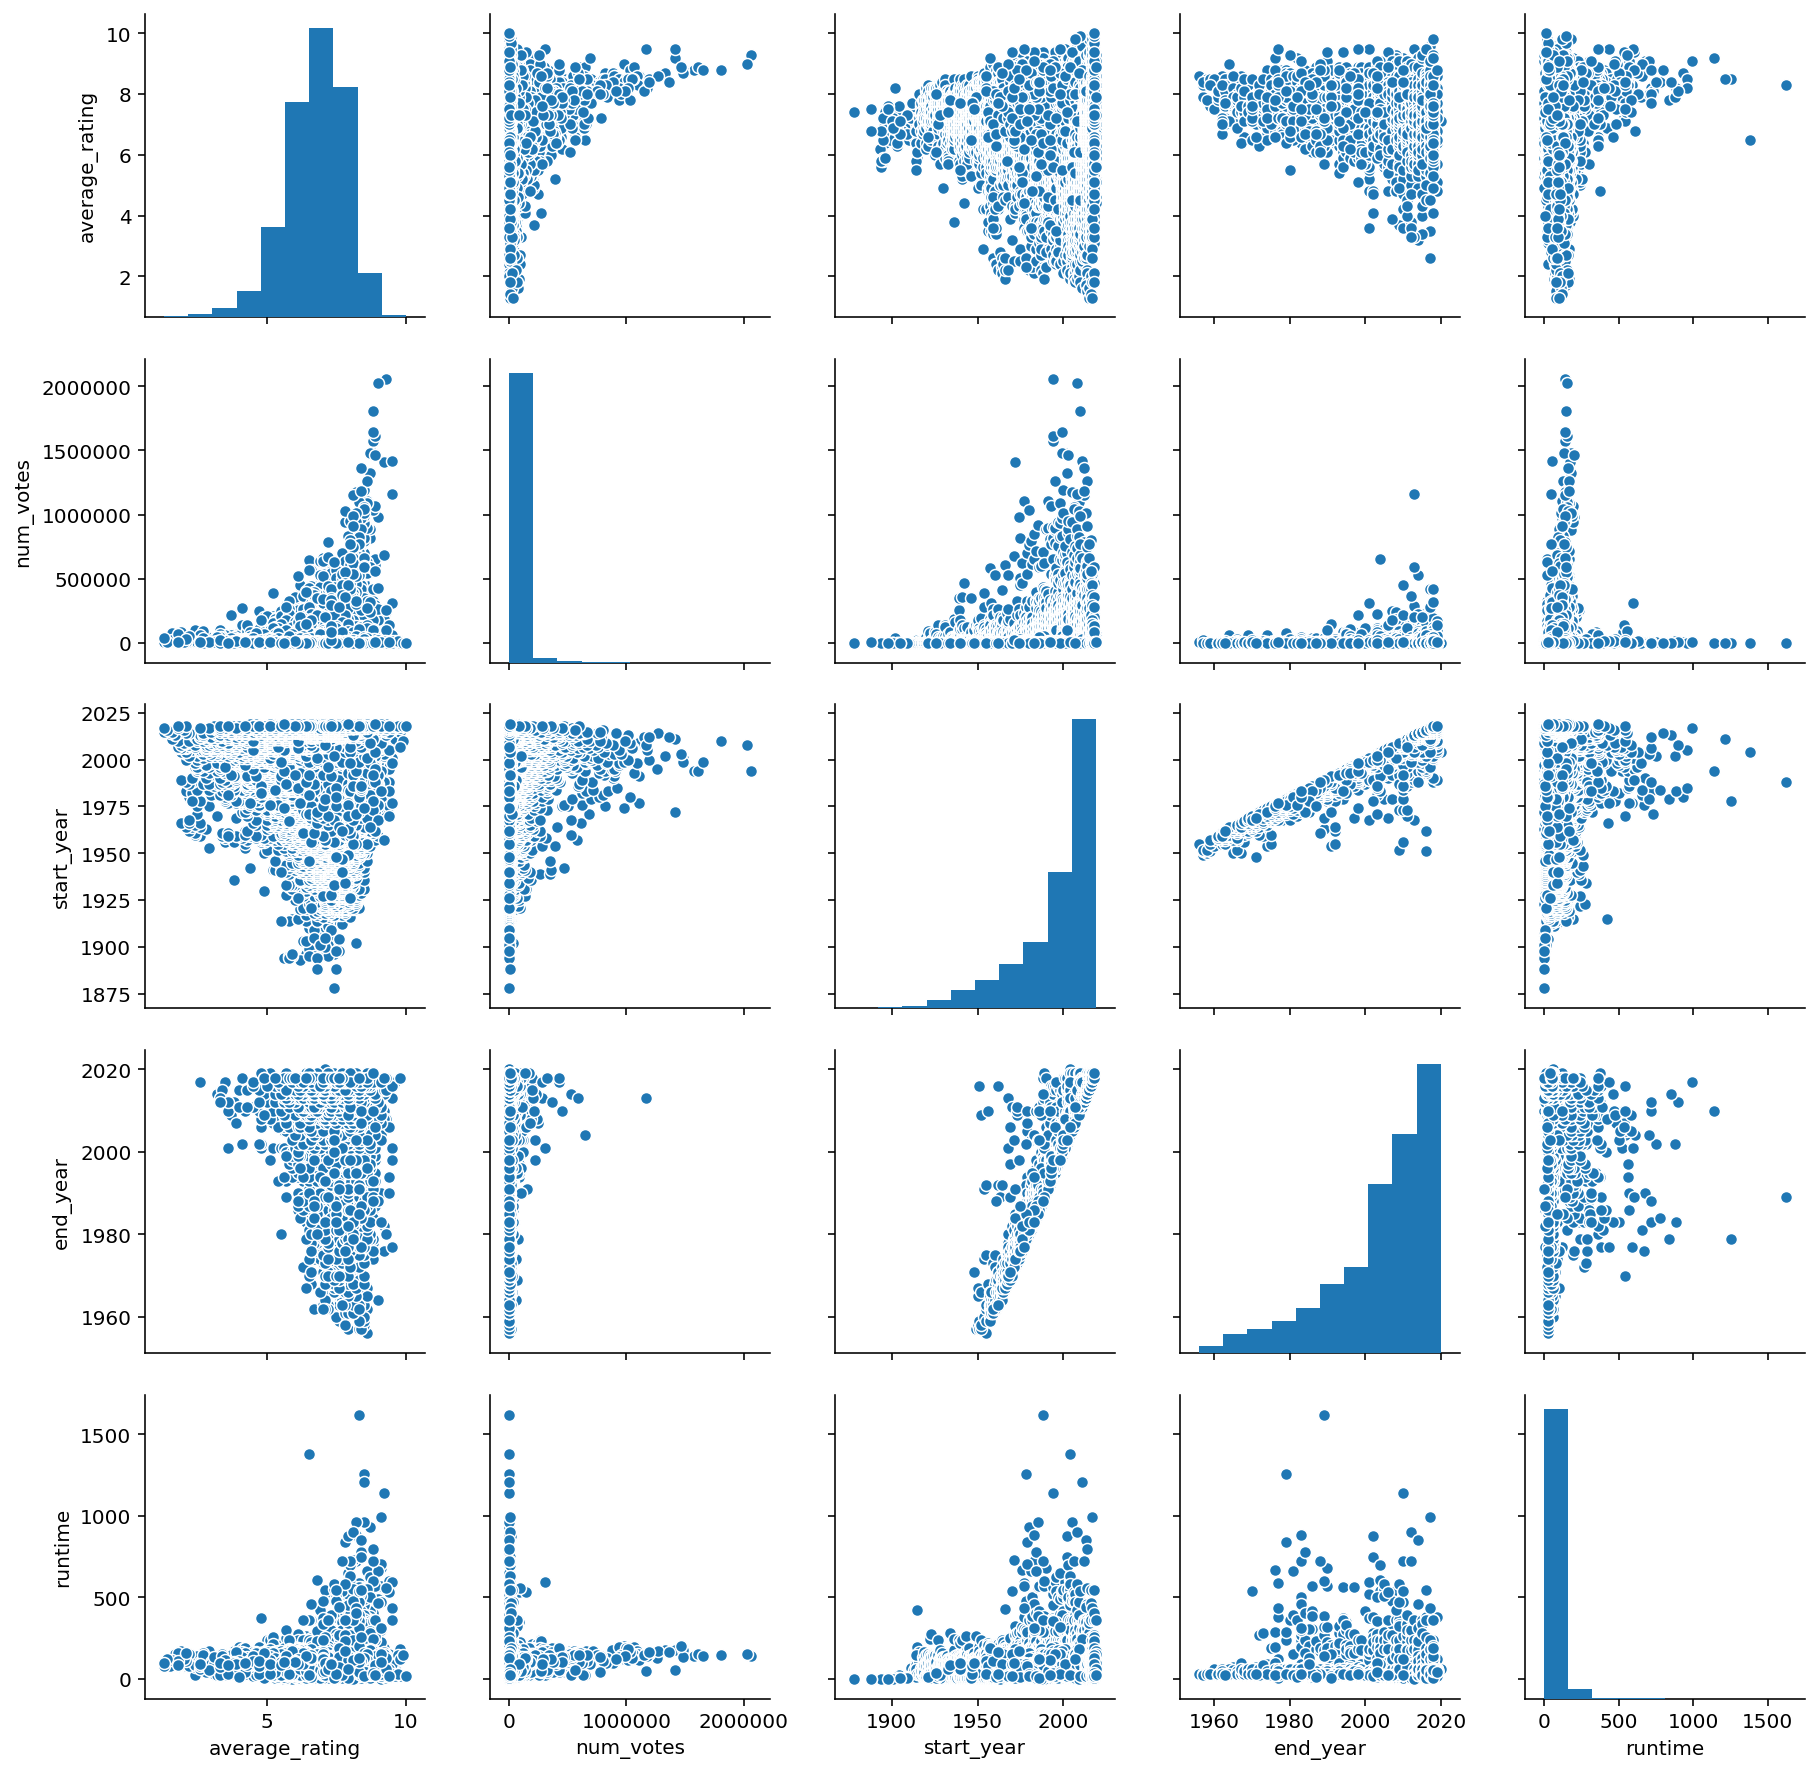

In [7]:
sns.pairplot(df.drop('is_adult', axis=1));

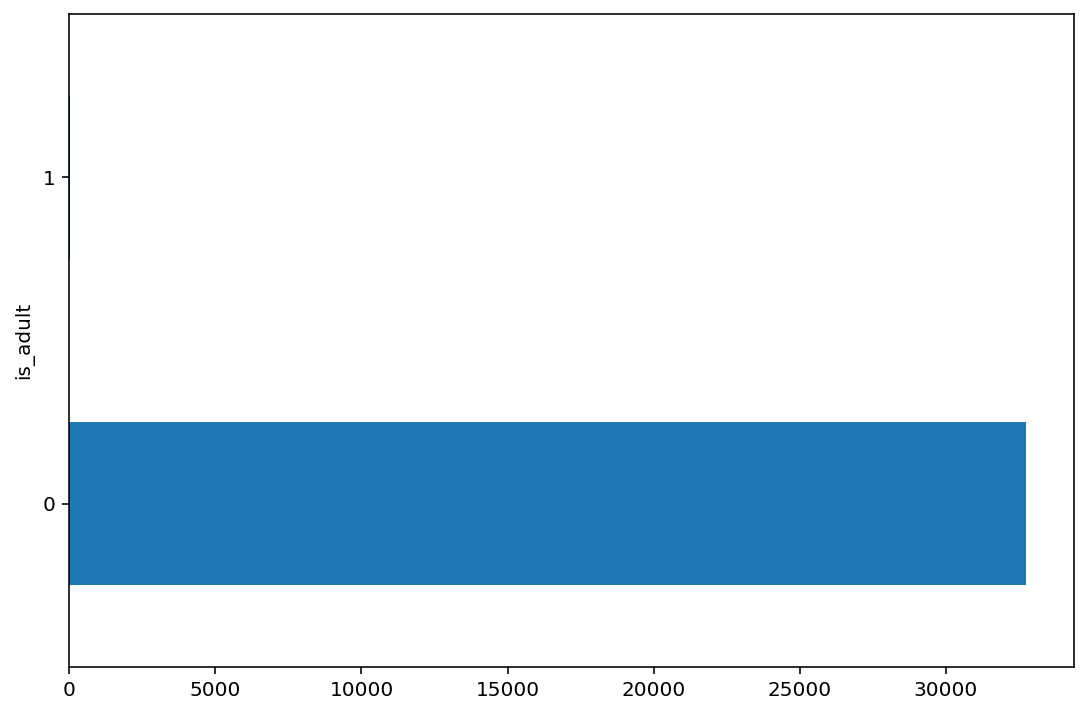

In [8]:
df.groupby('is_adult').size().plot.barh(figsize=(9, 6));

#### Preprocessing

In [9]:
df.isnull().sum()

movie_id              0
title                 0
primary_title         0
genres                0
kind                  0
description         163
image_url            10
average_rating        0
num_votes             0
start_year            0
end_year          29779
is_adult              0
runtime               0
dtype: int64

- Delete the `end_year` variable because it contains too many missing values

In [10]:
df = df.drop('end_year', axis=1)

In [11]:
cols = [
    'title',
    'kind',
    'average_rating',
    'num_votes',
    'start_year',
    'runtime',
    'genres',
]

- Convert string to int with label encoder

In [12]:
le = LabelEncoder()
dataset = df[cols].dropna().copy()
dataset['kind'] = le.fit_transform(dataset['kind'])

In [13]:
dataset.head()

,title,kind,average_rating,num_votes,start_year,runtime,genres
0,Juve contre Fantômas,0,6.9,1250,1913,61.0,"Crime,Drama"
1,His New Job,1,6.2,1411,1915,31.0,"Comedy,Short"
2,The Butcher Boy,1,6.4,1186,1917,30.0,"Comedy,Short"
3,The Musketeers of Pig Alley,1,6.7,1763,1912,17.0,"Crime,Drama,Short"
4,Le manoir du diable,1,6.7,2293,1896,3.0,"Horror,Short"


#### Feature Importances

In [14]:
def imp_df(column_names, importances):
    data = {
        'Feature': column_names,
        'Importance': importances,
    }
    df = pd.DataFrame(data) \
        .set_index('Feature') \
        .sort_values('Importance', ascending=False)
    
    return df

In [15]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

In [16]:
def drop_col_feat_imp(model, X_train, y_train, random_state=42):
    model_clone = clone(model)
    model_clone.random_state = random_state
    
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    
    importances = []
    
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis=1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis=1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    return imp_df(X_train.columns, importances)

In [17]:
X = dataset.drop(['average_rating', 'title', 'genres'], axis=1)
y = dataset['average_rating']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=0)

In [19]:
rf = RandomForestRegressor().fit(X_train, y_train)

In [20]:
rf.score(X_train, y_train) 

0.8553914617331639

In [21]:
rf.score(X_test, y_test)

0.16199459337386013

- Features importances by random forests

In [22]:
imp_df(X.columns, rf.feature_importances_)

,Importance
Feature,
num_votes,0.444409
runtime,0.253378
start_year,0.224061
kind,0.078152


- Feature importances with permutation
- See `references` for detailed information about `permutation_importances`

In [23]:
permutation_importances(rf, X_train, y_train, r2)

,Importance
Feature,
runtime,0.870083
num_votes,0.852447
start_year,0.734770
kind,0.398620


- Make `feature importances` comparisons by deleting columns one by one

In [24]:
drop_col_feat_imp(rf, X_train, y_train)

,Importance
Feature,
num_votes,0.409280
runtime,0.034837
start_year,0.029920
kind,0.001767


#### Scoring

In [25]:
dataset['score'] = (
    0.409280 * dataset['num_votes'] + 0.034837 * dataset['runtime'] + 
    0.029920 * dataset['start_year'] + 0.001767 * dataset['kind']
)

In [26]:
dataset = dataset.reset_index(drop=True)

In [27]:
dataset.sort_values(by='score', ascending=False).head(20)

,title,kind,average_rating,num_votes,start_year,runtime,genres,score
9966,The Shawshank Redemption,0,9.3,2058941,1994,142.0,Drama,842747.979814
18074,The Dark Knight,0,9.0,2025249,2008,152.0,"Action,Crime,Drama",828959.285304
22094,Inception,0,8.8,1804511,2010,148.0,"Action,Adventure,Sci-Fi",738615.557156
11837,Fight Club,0,8.8,1647695,1999,139.0,Drama,674433.262023
9935,Pulp Fiction,0,8.9,1609231,1994,154.0,"Crime,Drama",658691.089058
9792,Forrest Gump,0,8.8,1576601,1994,142.0,"Drama,Romance",645335.864614
11440,The Lord of the Rings: The Fellowship of the Ring,0,8.8,1482525,2001,178.0,"Adventure,Drama,Fantasy",606833.902906
11763,The Matrix,0,8.7,1478626,1999,136.0,"Action,Sci-Fi",605236.597192
12345,The Lord of the Rings: The Return of the King,0,8.9,1465962,2003,201.0,"Adventure,Drama,Fantasy",600055.859357
19823,Game of Thrones,4,9.5,1415970,2011,57.0,"Action,Adventure,Drama",579590.363497


In [28]:
dataset['score'].describe().T

count     32744.000000
mean       9868.711761
std       32118.758412
min         388.491193
25%         825.001411
50%        1578.744330
75%        4934.531974
max      842747.979814
Name: score, dtype: float64

#### Clustering

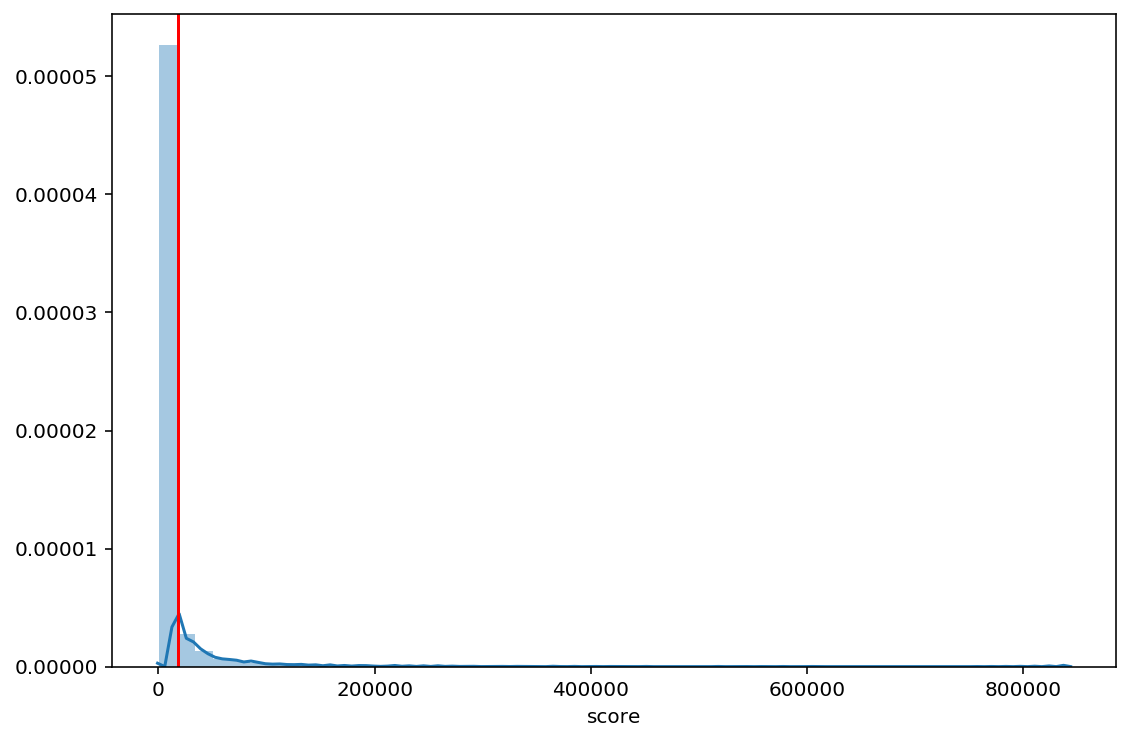

In [29]:
plt.figure(figsize=(9, 6))
sns.distplot(dataset['score'])
plt.axvline(18000, color='r');

- If I don't set the 18,000 limit, it collects all the values up to 18,000 in a cluster
- You can try if you want

In [30]:
vals = dataset['score'].values.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(vals)

s = np.linspace(400, 18000)
e = kde.score_samples(s.reshape(-1,1))

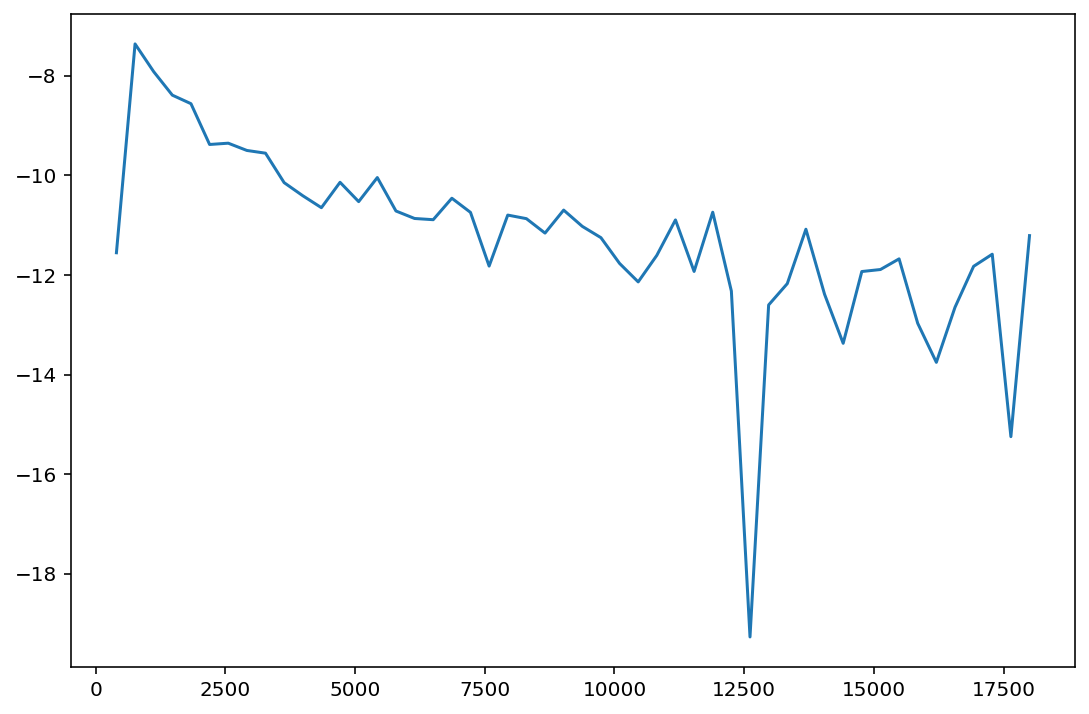

In [31]:
plt.figure(figsize=(9, 6))
plt.plot(s, e);

- Find min-max points of clusters
- Concat min points (`s[mi]`) and max points (`s[ma]`)
- Sort points
- And assign clusters

In [32]:
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]

In [33]:
points = np.concatenate((s[mi], s[ma]), axis=0)
buckets = []

for point in points:
    buckets.append(point)

In [34]:
buckets = np.array(buckets)
buckets.sort()

In [35]:
dataset['cluster'] = buckets.searchsorted(dataset.score)

In [36]:
dataset.groupby('cluster').size()

cluster
0      6853
1     12514
2      1177
3      3383
4       398
5       376
6       324
7       786
8       225
9       414
10      181
11      304
12      141
13      478
14      201
15       95
16       93
17      193
18      241
19      147
20      198
21      131
22      191
23       60
24     3640
dtype: int64

#### Recommendation

- Tf-idf vectorizer for finding similarity of genres
- Linear kernel creates an NxN matrix with similarities between movies

In [37]:
tfidf_vectorizer = TfidfVectorizer()
matrix = tfidf_vectorizer.fit_transform(dataset['genres'])

In [38]:
kernel = linear_kernel(matrix, matrix)

In [39]:
def get_recommendations(movie_index):
    print(dataset.iloc[movie_index])
    sim_scores = list(enumerate(kernel[movie_index]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    indexes = [i[0] for i in sim_scores if i[0] != movie_index and i[1] > .5]
    
    cond1 = (dataset.index.isin(indexes))
    cond2 = (dataset.cluster == dataset.iloc[movie_index]['cluster'])
    selected = dataset.loc[cond1 & cond2] \
        .sort_values(by='score', ascending=False).head(20)
    display(selected)

In [40]:
get_recommendations(9966)

title             The Shawshank Redemption
kind                                     0
average_rating                         9.3
num_votes                          2058941
start_year                            1994
runtime                                142
genres                               Drama
score                               842748
cluster                                 24
Name: 9966, dtype: object


,title,kind,average_rating,num_votes,start_year,runtime,genres,score,cluster
11837,Fight Club,0,8.8,1647695,1999,139.0,Drama,674433.262023,24
9792,Forrest Gump,0,8.8,1576601,1994,142.0,"Drama,Romance",645335.864614,24
12399,American Beauty,0,8.4,976865,1999,122.0,Drama,399875.367394,24
11316,Titanic,0,7.8,939706,1997,194.0,"Drama,Romance",384669.380298,24
11370,American History X,0,8.5,936534,1998,119.0,Drama,383368.561283,24
5075,One Flew Over the Cuckoo's Nest,0,8.7,817262,1975,133.0,Drama,334552.716681,24
11062,Good Will Hunting,0,8.3,752920,1997,126.0,"Drama,Romance",308219.237302,24
20129,Slumdog Millionaire,0,8.0,738633,2008,120.0,"Drama,Romance",302371.974040,24
12549,Requiem for a Dream,0,8.3,689795,2000,102.0,Drama,282382.690974,24
21175,Gran Torino,0,8.1,661699,2008,116.0,Drama,270884.287172,24


In [41]:
get_recommendations(16040)

title                         Batman Begins
kind                                      0
average_rating                          8.2
num_votes                           1173791
start_year                             2005
runtime                                 140
genres            Action,Adventure,Thriller
score                                480474
cluster                                  24
Name: 16040, dtype: object


,title,kind,average_rating,num_votes,start_year,runtime,genres,score,cluster
19823,Game of Thrones,4,9.5,1415970,2011,57.0,"Action,Adventure,Drama",579590.363497,24
21978,The Dark Knight Rises,0,8.4,1364364,2012,164.0,"Action,Thriller",558472.810228,24
12443,Gladiator,0,8.5,1190625,2000,155.0,"Action,Adventure,Drama",487364.239735,24
5452,Star Wars,0,8.6,1103174,1977,121.0,"Action,Adventure,Fantasy",451570.421837,24
5902,Star Wars: Episode V - The Empire Strikes Back,0,8.8,1033352,1980,124.0,"Action,Adventure,Fantasy",422993.867948,24
18680,Avatar,0,7.8,1028434,2009,162.0,"Action,Adventure,Fantasy",420983.220394,24
15192,Pirates of the Caribbean: The Curse of the Bla...,0,8.0,952398,2003,143.0,"Action,Adventure,Fantasy",389862.364891,24
25124,Guardians of the Galaxy,0,8.1,913090,2014,121.0,"Action,Adventure,Comedy",373773.949357,24
14043,Kill Bill: Vol. 1,0,8.1,890574,2003,111.0,"Action,Crime,Thriller",364557.923387,24
6615,Star Wars: Episode VI - Return of the Jedi,0,8.3,846987,1983,131.0,"Action,Adventure,Fantasy",346718.734367,24


#### References
- https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
- https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments
- https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html